In [241]:
# import argparse
import os
import pickle
# import time
# from itertools import product
# from math import inf, pi

import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint
import jax.debug as jdb
from functools import partial
import numpy as np

from tqdm.auto import tqdm

# from dynamics import prior, disturbance, plant
# from utils import params_to_posdef
from utils import random_ragged_spline, spline
from utils import (tree_normsq, rk38_step, epoch,   # noqa: E402
                   odeint_fixed_step, odeint_ckpt, random_ragged_spline, spline,
            params_to_cholesky, params_to_posdef, vee, hat,
            
            quaternion_to_rotation_matrix, flat_rotation_matrix_to_quaternion, 
            quaternion_multiply)

# from functools import partial
import matplotlib.pyplot as plt
# import csv

plt.rcParams.update({'font.size': 24})

In [242]:
# trial_name = 'hardware_reg_P_1e-1'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.1000.pkl'
# trial_name = 'hardware_reg_P_1e-2'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.0100.pkl'
# trial_name = 'hardware_mac_kR_reg_P_1'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=1.0000.pkl'
trial_name = 'hardware_mac_kR_reg_P_10'
filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=10.0000.pkl'
pkl = f'{trial_name}/{filename}'
with open(f'train_results/{pkl}', 'rb') as file:
    raw = pickle.load(file)

(37,)
eigs_P: [1.4971976  1.1919371  1.1499267  1.0546598  0.7783406  0.84308535
 0.8716363  0.88177276 1.0328338  0.97763044 1.2763364  0.9529088
 1.0212735  1.0038444  0.7148982  0.8995411  1.1178126  1.271465
 1.3136824  1.0386201  1.3015068  1.2184546  1.4312398  0.9097746
 1.6767279  0.69469786 0.7668512  0.89729446 0.92686373 1.2741731
 1.1600171  1.3194684 ]
eigs_Λ: [0.794434   1.276056   0.80103135]
eigs_K: [0.70858085 0.75645536 0.5869476 ]


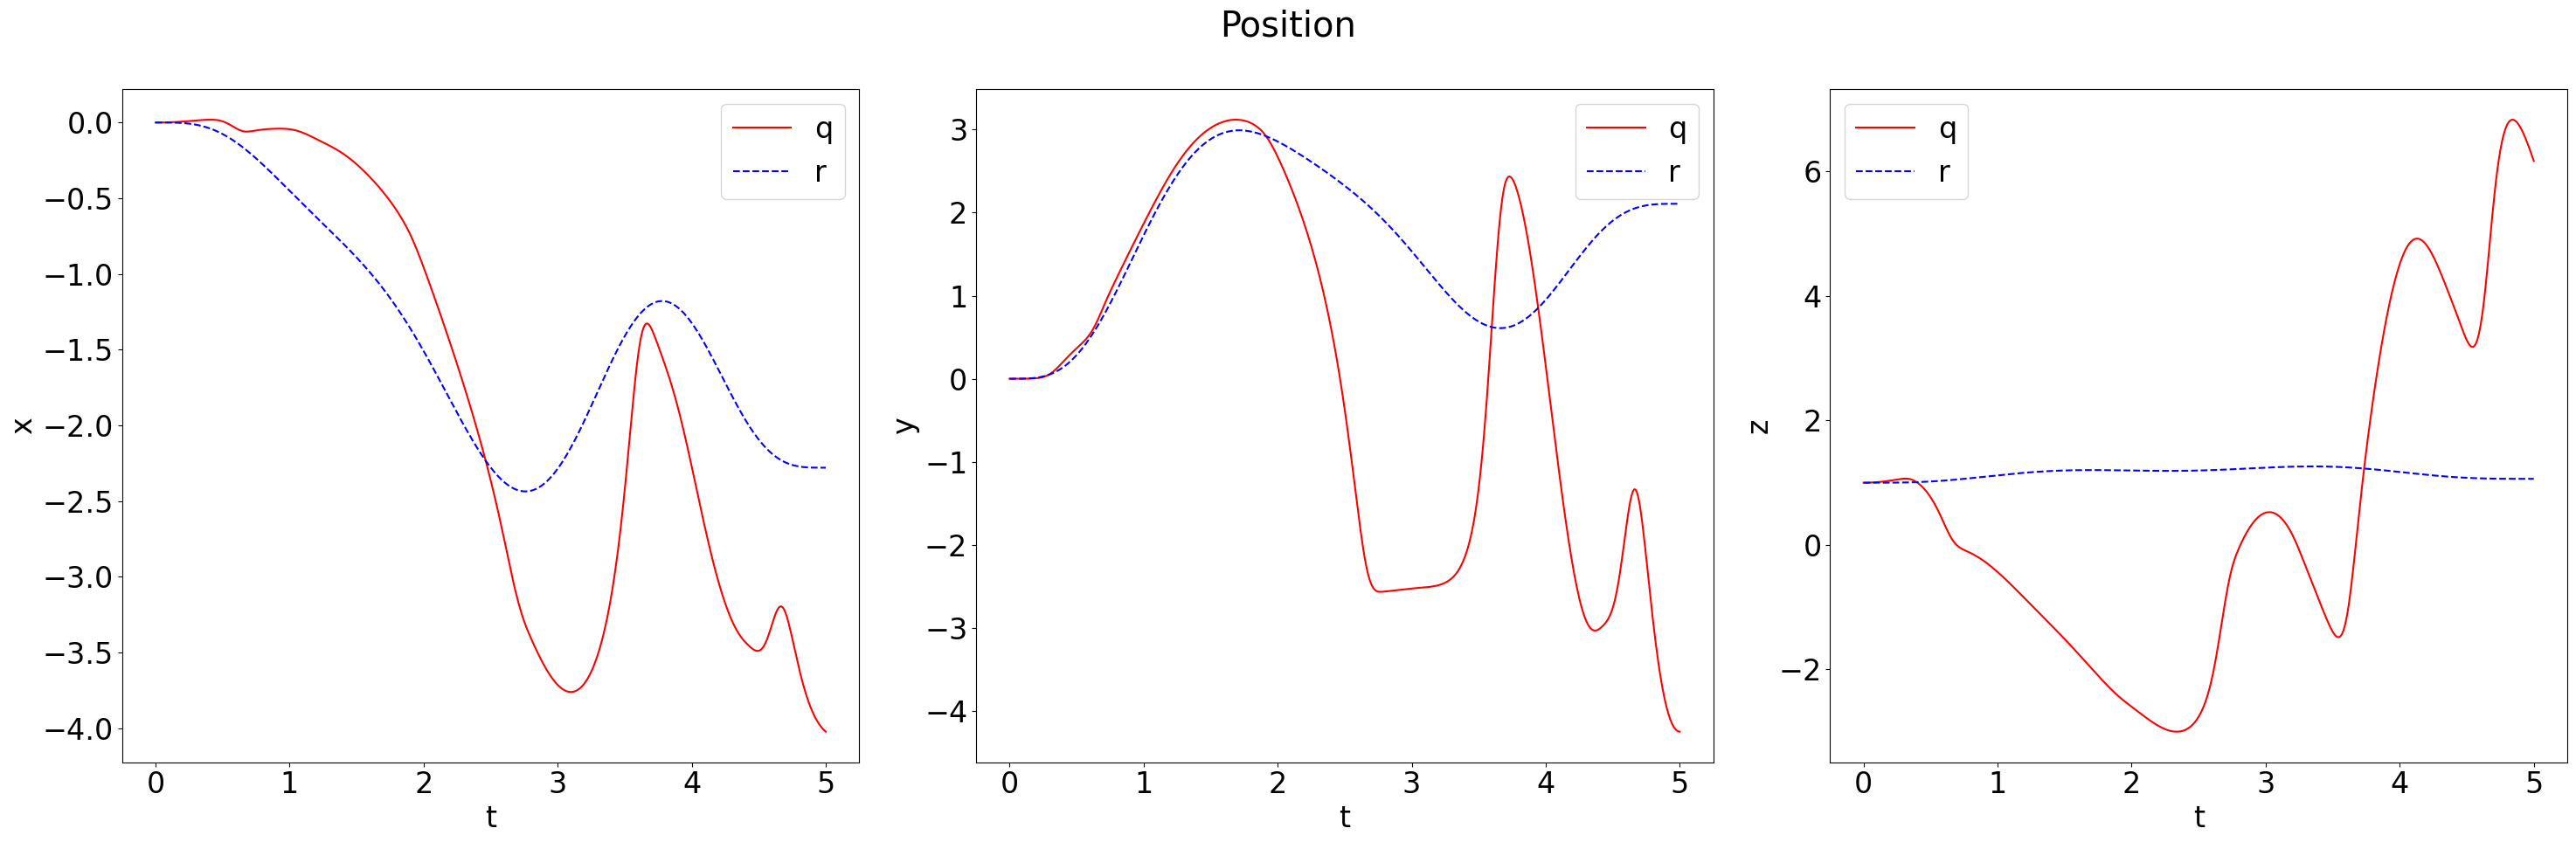

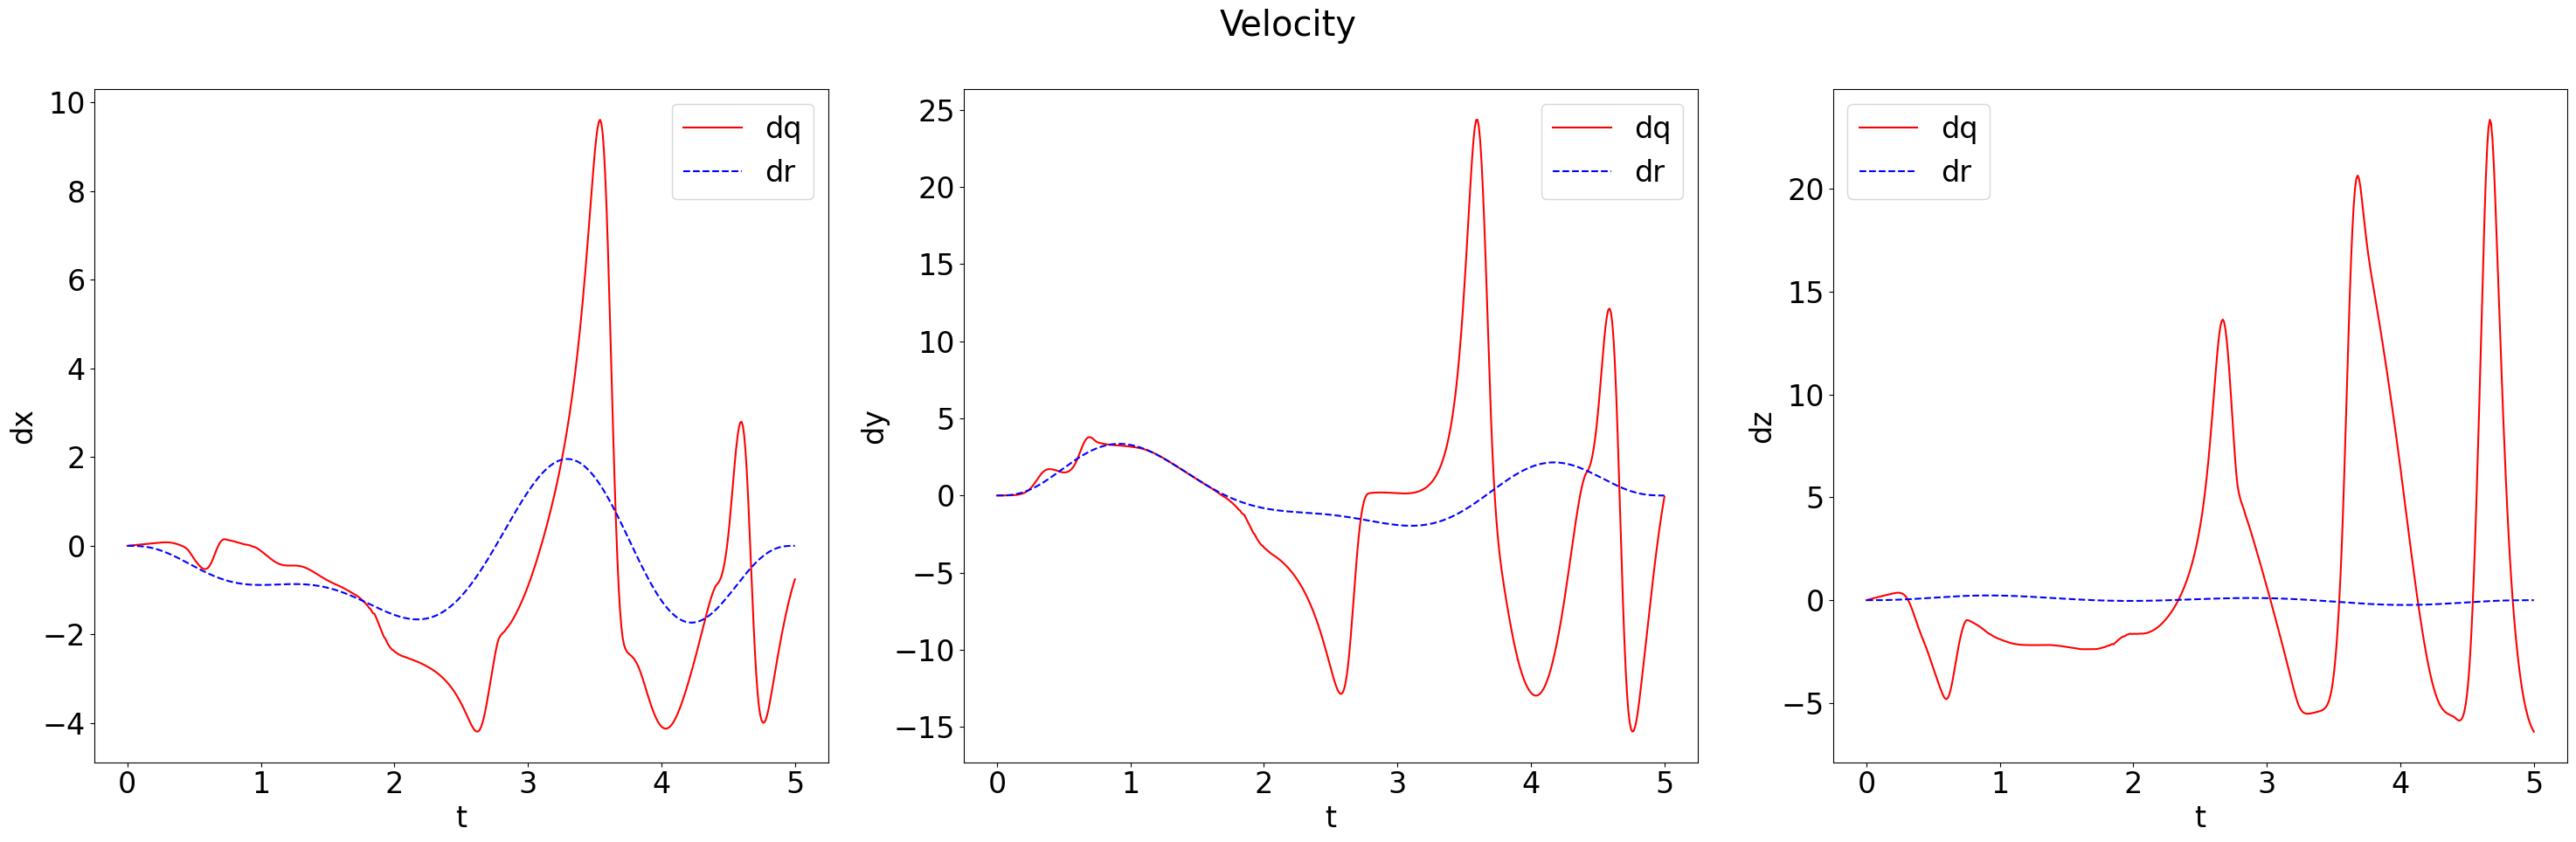

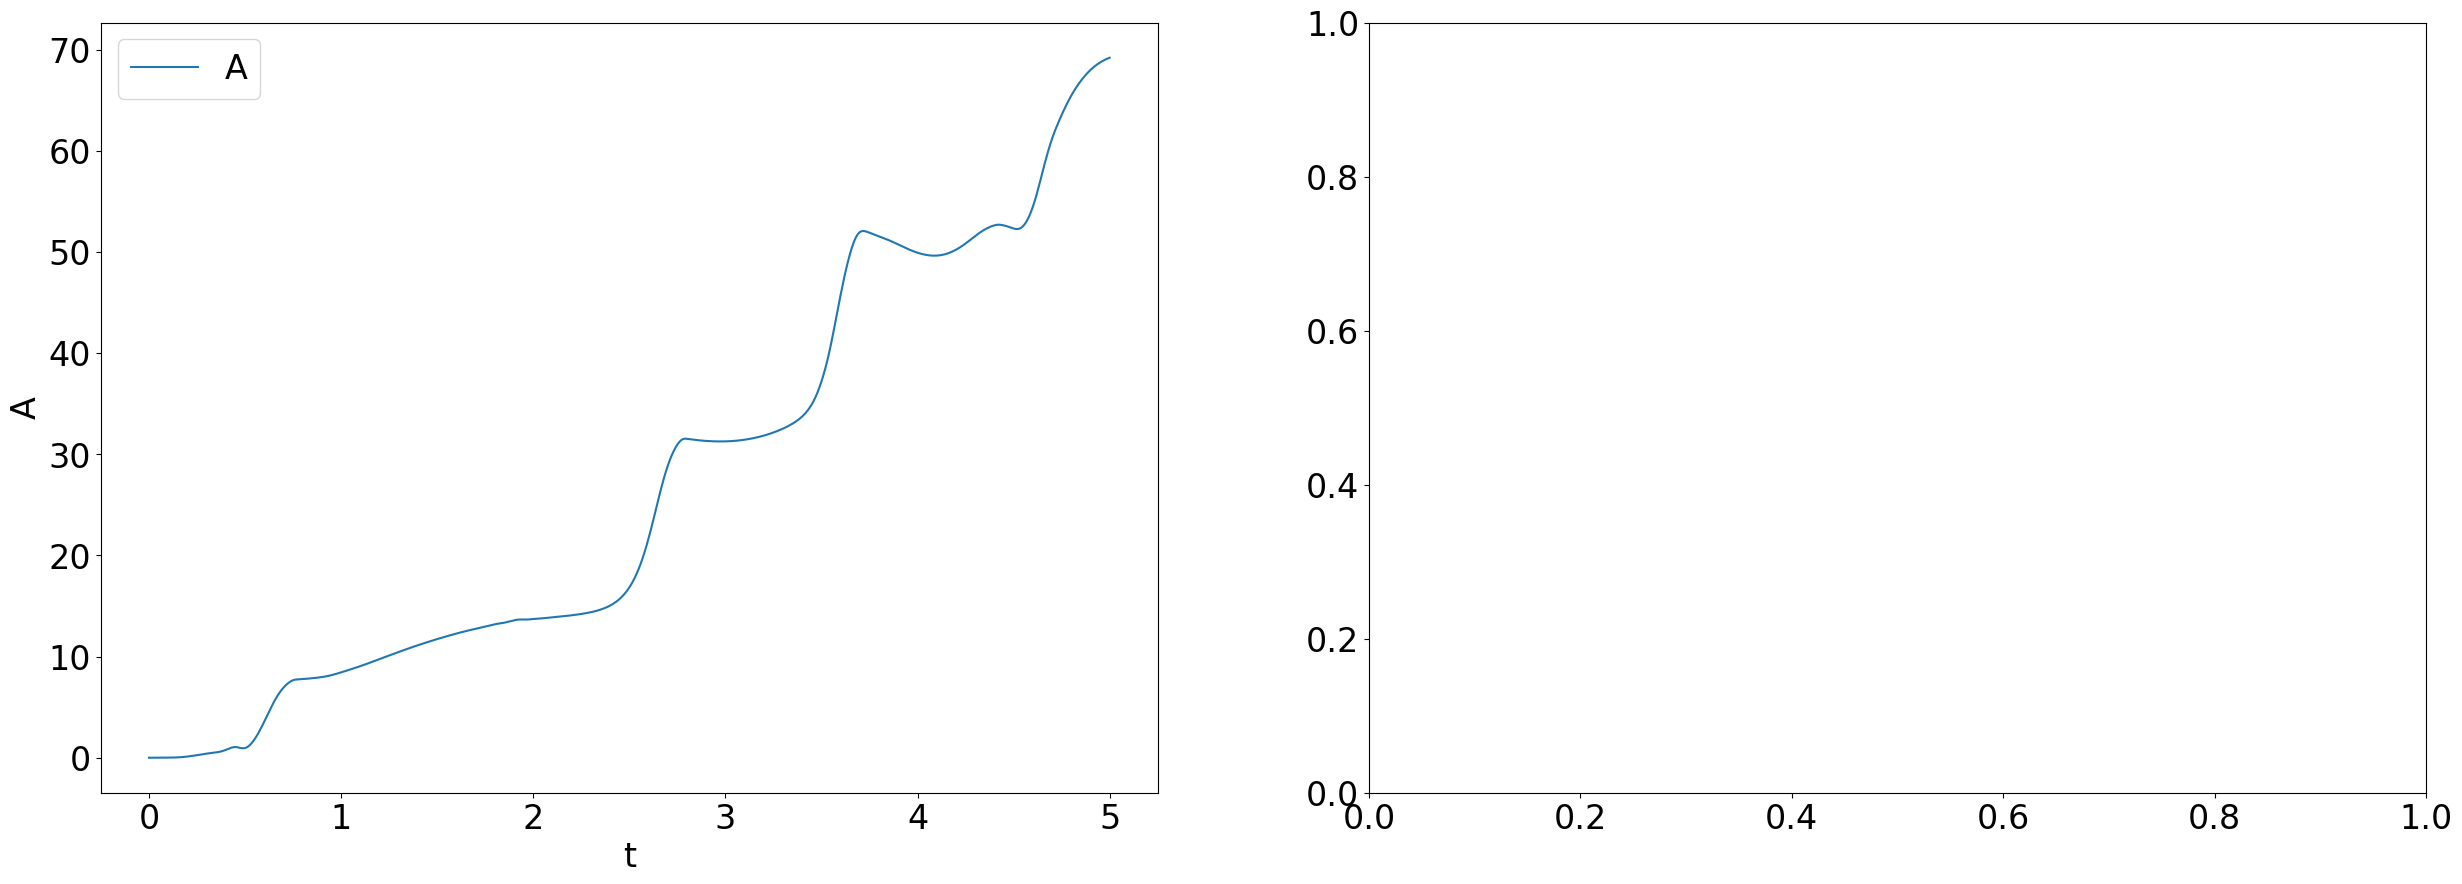

In [243]:
epoch_i = 999
# mystery_i = 0
# for k,v in raw['train_lossaux_history'][epoch_i].items():
#     if type(v) is list or type(v) is tuple:
#         for i in v:
#             print(k, i.shape)
#     else:
#         print(k, v.shape)

def validate_model(raw, epoch_i):
    hparams = raw['hparams']
    dt = hparams['meta']['dt']
    T = hparams['meta']['T']
    coefs = raw['coefs']
    max_ref = raw['max_ref']
    min_ref = raw['min_ref']
    t_knots = raw['t_knots']

    A = raw['train_lossaux_history'][epoch_i]['A']
    W = raw['train_lossaux_history'][epoch_i]['W']
    b = raw['train_lossaux_history'][epoch_i]['b']
    eigs_K = raw['train_lossaux_history'][epoch_i]['eigs_K']
    eigs_P = raw['train_lossaux_history'][epoch_i]['eigs_P']
    eigs_Λ = raw['train_lossaux_history'][epoch_i]['eigs_Λ']
    control_loss = raw['train_lossaux_history'][epoch_i]['control_loss']
    estimation_loss = raw['train_lossaux_history'][epoch_i]['estimation_loss']
    tracking_loss = raw['train_lossaux_history'][epoch_i]['tracking_loss']
    l2_penalty = raw['train_lossaux_history'][epoch_i]['l2_penalty']
    reg_P_penalty = raw['train_lossaux_history'][epoch_i]['reg_P_penalty']
    pnorm = raw['train_lossaux_history'][epoch_i]['pnorm']
    x = raw['train_lossaux_history'][epoch_i]['x']

    # loss = (tracking_loss
    #             + regularizer_ctrl*control_loss
    #             + regularizer_error*estimation_loss
    #             + regularizer_l2*l2_penalty
    #             ) / normalizer + regularizer_P * reg_P_penalty

    print(tracking_loss.shape)

    mystery_i = 0
    
    def reference(t):
        # print([spline(t, t_knots[mystery_i], c[mystery_i]) for c in coefs])
        r = jnp.array([spline(t, t_knots[mystery_i], c[mystery_i]) for c in coefs]) + jnp.array([0, 0, 1])
        r = jnp.clip(r, min_ref, max_ref)
        return r

    num_steps = int(np.maximum(np.abs((T - 0)/dt), 1))
    ts = jnp.linspace(0, T, num_steps + 1)
    r = jax.vmap(reference)(ts)
    dr = jax.vmap(jax.jacfwd(reference))(ts)

    fig, ax = plt.subplots(1, 3, figsize=(30, 10))
    ax[0].plot(ts, x[:, 0], 'r-', label='q')
    ax[0].plot(ts, r[:, 0], 'b--', label='r')
    ax[0].set_ylabel('x')
    ax[0].set_xlabel('t')
    ax[0].legend()

    ax[1].plot(ts, x[:, 1], 'r-', label='q')
    ax[1].plot(ts, r[:, 1], 'b--', label='r')
    ax[1].set_ylabel('y')
    ax[1].set_xlabel('t')
    ax[1].legend()

    ax[2].plot(ts, x[:, 2], 'r-', label='q')
    ax[2].plot(ts, r[:, 2], 'b--', label='r')
    ax[2].set_ylabel('z')
    ax[2].set_xlabel('t')
    ax[2].legend()
    
    fig.suptitle(f'Position')
    fig.tight_layout()

    fig, ax = plt.subplots(1, 3, figsize=(30, 10))
    ax[0].plot(ts, x[:, 3], 'r-', label='dq')
    ax[0].plot(ts, dr[:, 0], 'b--', label='dr')
    ax[0].set_ylabel('dx')
    ax[0].set_xlabel('t')
    ax[0].legend()

    ax[1].plot(ts, x[:, 4], 'r-', label='dq')
    ax[1].plot(ts, dr[:, 1], 'b--', label='dr')
    ax[1].set_ylabel('dy')
    ax[1].set_xlabel('t')
    ax[1].legend()

    ax[2].plot(ts, x[:, 5], 'r-', label='dq')
    ax[2].plot(ts, dr[:, 2], 'b--', label='dr')
    ax[2].set_ylabel('dz')
    ax[2].set_xlabel('t')
    ax[2].legend()
    
    fig.suptitle(f'Velocity')
    fig.tight_layout()

    A_norm = jnp.linalg.norm(A, axis=(1,2))

    fig, ax = plt.subplots(1, 2, figsize=(30, 10))

    ax[0].plot(ts, A_norm, label='A')
    ax[0].set_ylabel('A')
    ax[0].set_xlabel('t')
    ax[0].legend()

    print('eigs_P:', eigs_P)
    print('eigs_Λ:', eigs_Λ)
    print('eigs_K:', eigs_K)

    # P_small = 1e-3*jnp.eye(32)
    # print('eigs_P_small:', jnp.linalg.eigvals(P_small))

validate_model(raw, epoch_i)

# print(len(raw['train_lossaux_history']))

In [244]:
def validate_loss(raw, epoch_i):
    hparams = raw['hparams']
    dt = hparams['meta']['dt']
    T = hparams['meta']['T']
    num_refs = hparams['meta']['num_refs']
    coefs = raw['coefs']
    max_ref = raw['max_ref']
    min_ref = raw['min_ref']
    t_knots = raw['t_knots']

    A = raw['train_lossaux_history'][epoch_i]['A']
    W = raw['train_lossaux_history'][epoch_i]['W']
    b = raw['train_lossaux_history'][epoch_i]['b']
    eigs_K = raw['train_lossaux_history'][epoch_i]['eigs_K']
    eigs_P = raw['train_lossaux_history'][epoch_i]['eigs_P']
    eigs_Λ = raw['train_lossaux_history'][epoch_i]['eigs_Λ']
    control_loss = raw['train_lossaux_history'][epoch_i]['control_loss']
    estimation_loss = raw['train_lossaux_history'][epoch_i]['estimation_loss']
    tracking_loss = raw['train_lossaux_history'][epoch_i]['tracking_loss']
    l2_penalty = raw['train_lossaux_history'][epoch_i]['l2_penalty']
    reg_P_penalty = raw['train_lossaux_history'][epoch_i]['reg_P_penalty']
    pnorm = raw['train_lossaux_history'][epoch_i]['pnorm']
    x = raw['train_lossaux_history'][epoch_i]['x']
    
    num_models = len(control_loss)

    control_loss = jnp.sum(control_loss)
    estimation_loss = jnp.sum(estimation_loss)
    tracking_loss = jnp.sum(tracking_loss)

    normalizer = T * num_refs * num_models

    regularizer_l2 = hparams['meta']['regularizer_l2']
    regularizer_ctrl = hparams['meta']['regularizer_ctrl']
    regularizer_error = hparams['meta']['regularizer_error']
    regularizer_P = hparams['meta']['regularizer_P']

    loss = (tracking_loss
                + regularizer_ctrl*control_loss
                + regularizer_error*estimation_loss
                + regularizer_l2*l2_penalty
                ) / normalizer + regularizer_P * reg_P_penalty
    
    # for i in range(num_models):
    # print(i)
    i = 0
    # print('total loss:', loss[i])
    # print('tracking_loss:', tracking_loss[i]/normalizer)
    # print('control_loss:', regularizer_ctrl*control_loss[i]/normalizer)
    # print('estimation_loss:', regularizer_error*estimation_loss[i]/normalizer)
    # print('l2_penalty:', regularizer_l2*l2_penalty/normalizer)
    # print('reg_P_penalty:', regularizer_P*reg_P_penalty)

    print('total loss:', loss)
    print('tracking_loss:', tracking_loss/normalizer)
    print('control_loss:', regularizer_ctrl*control_loss/normalizer)
    print('estimation_loss:', regularizer_error*estimation_loss/normalizer)
    print('l2_penalty:', regularizer_l2*l2_penalty/normalizer)
    print('reg_P_penalty:', regularizer_P*reg_P_penalty)

epoch_i = 999
validate_loss(raw, epoch_i)


total loss: 116.42052
tracking_loss: 53.932594
control_loss: 3.5846434
estimation_loss: 0.0
l2_penalty: 9.3830766e-07
reg_P_penalty: 58.90328


In [245]:
epoch_i = 999
# mystery_i = 0
# for k,v in raw['train_lossaux_history'][epoch_i].items():
#     if type(v) is list or type(v) is tuple:
#         for i in v:
#             print(k, i.shape)
#     else:
#         print(k, v.shape)

def validate_model(raw, epoch_i):
    hparams = raw['hparams']
    dt = hparams['meta']['dt']
    T = hparams['meta']['T']

    for epoch in range(2): 

        A = raw['train_lossaux_history'][epoch_i]['A']
        W = raw['train_lossaux_history'][epoch_i]['W']
        b = raw['train_lossaux_history'][epoch_i]['b']
        # coefs = raw['train_lossaux_history'][epoch_i]['coefs']
        control_loss = raw['train_lossaux_history'][epoch_i]['control_loss']
        eigs_K = raw['train_lossaux_history'][epoch_i]['eigs_K']
        eigs_P = raw['train_lossaux_history'][epoch_i]['eigs_P']
        eigs_Λ = raw['train_lossaux_history'][epoch_i]['eigs_Λ']
        estimation_loss = raw['train_lossaux_history'][epoch_i]['estimation_loss']
        l2_penalty = raw['train_lossaux_history'][epoch_i]['l2_penalty']
        # max_ref = raw['train_lossaux_history'][epoch_i]['max_ref']
        # min_ref = raw['train_lossaux_history'][epoch_i]['min_ref']
        pnorm = raw['train_lossaux_history'][epoch_i]['pnorm']
        reg_P_penalty = raw['train_lossaux_history'][epoch_i]['reg_P_penalty']
        # t_knots = raw['train_lossaux_history'][epoch_i]['t_knots']
        tracking_loss = raw['train_lossaux_history'][epoch_i]['tracking_loss']
        x = raw['train_lossaux_history'][epoch_i]['x']

        print('t_knots', t_knots[0])
        for c in coefs:
            print('c', c[0])
        print('min_ref', min_ref)
        print('max_ref', max_ref)  

validate_model(raw, epoch_i)

# print(len(raw['train_lossaux_history']))

NameError: name 't_knots' is not defined